- explore the spectral content of your data (frequency and time-frequency). 

这里使用了Epochs的方式

Use the somatosensory dataset that contains so-called event related synchronizations (ERS) / desynchronizations (ERD) in the beta band.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.time_frequency import tfr_morlet,psd_multitaper
from mne.datasets import somato

In [4]:
data_path = somato.data_path()
raw_fname = data_path + '/MEG/somato/sef_raw_sss.fif'

In [5]:
## Load the raw data
raw = mne.io.read_raw_fif(raw_fname)
events = mne.find_events(raw,stim_channel='STI 014')

Opening raw data file /home/reallocing/mne_data/MNE-somato-data/MEG/somato/sef_raw_sss.fif...
    Range : 237600 ... 506999 =    791.189 ...  1688.266 secs
Ready.
Current compensation grade : 0
111 events found
Event IDs: [1]


In [6]:
# picks MEG gradiometers
picks = mne.pick_types(raw.info, meg='grad', eeg=False, eog=True, stim=False)
picks

array([  0,   1,   3,   4,   6,   7,   9,  10,  12,  13,  15,  16,  18,
        19,  21,  22,  24,  25,  27,  28,  30,  31,  33,  34,  36,  37,
        39,  40,  42,  43,  45,  46,  48,  49,  51,  52,  54,  55,  57,
        58,  60,  61,  63,  64,  66,  67,  69,  70,  72,  73,  75,  76,
        78,  79,  81,  82,  84,  85,  87,  88,  90,  91,  93,  94,  96,
        97,  99, 100, 102, 103, 105, 106, 108, 109, 111, 112, 114, 115,
       117, 118, 120, 121, 123, 124, 126, 127, 129, 130, 132, 133, 135,
       136, 138, 139, 141, 142, 144, 145, 147, 148, 150, 151, 153, 154,
       156, 157, 159, 160, 162, 163, 165, 166, 168, 169, 171, 172, 174,
       175, 177, 178, 180, 181, 183, 184, 186, 187, 189, 190, 192, 193,
       195, 196, 198, 199, 201, 202, 204, 205, 207, 208, 210, 211, 213,
       214, 216, 217, 219, 220, 222, 223, 225, 226, 228, 229, 231, 232,
       234, 235, 237, 238, 240, 241, 243, 244, 246, 247, 249, 250, 252,
       253, 255, 256, 258, 259, 261, 262, 264, 265, 267, 268, 27

In [7]:
## Construct Epochs
event_id,tmin,tmax = 1,-1.,3.
baseline = (None,0)
reject = dict(grad=4000e-13, eog=350e-6)
epochs = mne.Epochs(raw,events,event_id,tmin,tmax,picks=picks,baseline=baseline,reject=reject,preload=True)
epochs.resample(150.,npad='auto') # resample to reduce computation time

111 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 111 events and 1202 original time points ...
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
3 bad epochs dropped


<Epochs  |   108 events (all good), -0.998976 - 2.99436 sec, baseline [None, 0], ~104.9 MB, data loaded,
 '1': 108>

### Frequency analysis

    Using multitaper spectrum estimation with 7 DPSS windows


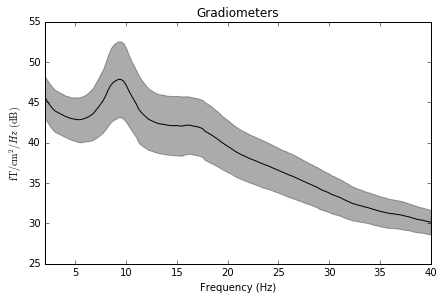

In [8]:
#  check out all channel types by averaging across epochs.
epochs.plot_psd(fmin=2.,fmax=40.);

    Using multitaper spectrum estimation with 7 DPSS windows


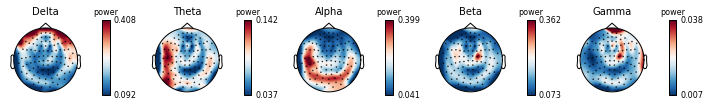

In [9]:
# take a look at the spatial distributions of the PSD.
epochs.plot_psd_topomap(ch_type='grad',normalize=True);

#### Alternatively, you can also create PSDs from Epochs objects with functions that start with psd_ such as mne.time_frequency.psd_multitaper() and mne.time_frequency.psd_welch().

    Using multitaper spectrum estimation with 7 DPSS windows


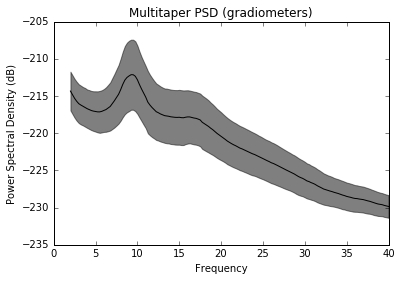

In [10]:
f, ax = plt.subplots()
psds, freqs = psd_multitaper(epochs, fmin=2, fmax=40, n_jobs=1)
psds = 10. * np.log10(psds)
psds_mean = psds.mean(0).mean(0)
psds_std = psds.mean(0).std(0)

ax.plot(freqs, psds_mean, color='k')
ax.fill_between(freqs, psds_mean - psds_std, psds_mean + psds_std,
                color='k', alpha=.5)
ax.set(title='Multitaper PSD (gradiometers)', xlabel='Frequency',
       ylabel='Power Spectral Density (dB)')
plt.show()

### Time-frequency analysis: power and inter-trial coherence

We now compute time-frequency representations (TFRs) from our Epochs. We’ll look at power and inter-trial coherence (ITC).
> To this we’ll use the function [mne.time_frequency.tfr_morlet()](https://martinos.org/mne/stable/generated/mne.time_frequency.tfr_morlet.html#mne.time_frequency.tfr_morlet) but you can also use [mne.time_frequency.tfr_multitaper()](https://martinos.org/mne/stable/generated/mne.time_frequency.tfr_multitaper.html#mne.time_frequency.tfr_multitaper) or [mne.time_frequency.tfr_stockwell()](https://martinos.org/mne/stable/generated/mne.time_frequency.tfr_stockwell.html#mne.time_frequency.tfr_stockwell).

In [11]:
# define frequencies of interest (log-spaced)
freqs = np.logspace(*np.log10([6, 35]), num=8) # frequencies of interest
n_cycles = freqs / 2.  # different number of cycle per frequency, number of cycles in Morlet wavelet
power, itc = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=True, decim=3, n_jobs=1)

In [12]:
print("freqs",freqs) #The frequencies in Hz.
print("n_cycles",n_cycles) #The number of cycles globally or for each frequency.

('freqs', array([  6.        ,   7.71912254,   9.93080879,  12.77618833,
        16.43682721,  21.1463139 ,  27.2051647 ,  35.        ]))
('n_cycles', array([  3.        ,   3.85956127,   4.9654044 ,   6.38809416,
         8.21841361,  10.57315695,  13.60258235,  17.5       ]))


In [13]:
power

<AverageTFR  |  time : [-0.998976, 2.981024], freq : [6.000000, 35.000000], nave : 108, channels : 204, ~6.0 MB>

#### Example 2:Time-Frequency: Induced power and inter trial coherence

No baseline correction applied


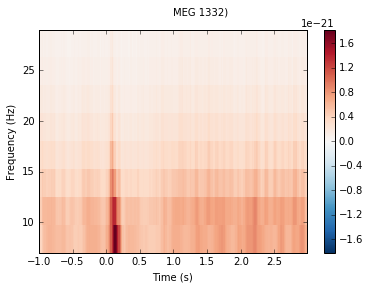

In [32]:
import numpy as np  # noqa
n_cycles = 2  # number of cycles in Morlet wavelet
freqs = np.arange(7, 30, 3)  # frequencies of interest
# Compute induced power and phase-locking values and plot gradiometers:
from mne.time_frequency import tfr_morlet  # noqa
power, itc = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles,
                        return_itc=True, decim=3, n_jobs=1)
power.plot([power.ch_names.index('MEG 1332')]); ## 通过指定MEG名来画

No baseline correction applied


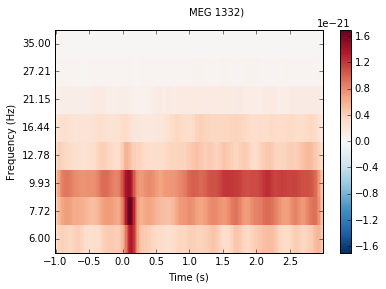

In [31]:
## 使用原tfr_morlet画图
power.plot([power.ch_names.index('MEG 1332')]); ## 通过指定MEG名来画

### Inspect power

Applying baseline correction (mode: logratio)


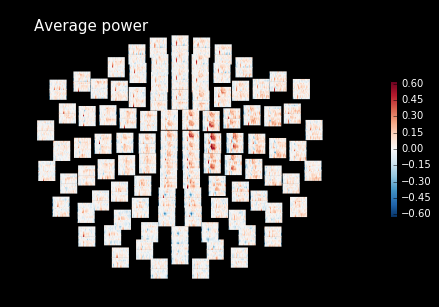

Applying baseline correction (mode: logratio)


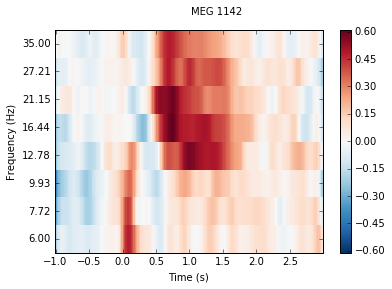

Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)


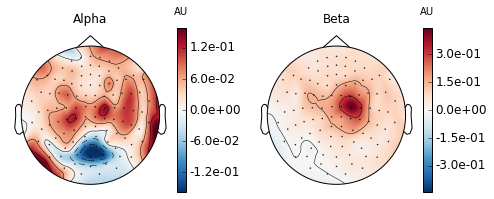

In [18]:
power.plot_topo(baseline=(-0.5, 0), mode='logratio', title='Average power')
power.plot([82], baseline=(-0.5, 0), mode='logratio', title=power.ch_names[82])

fig, axis = plt.subplots(1, 2, figsize=(7, 4))
power.plot_topomap(ch_type='grad', tmin=0.5, tmax=1.5, fmin=8, fmax=12,
                   baseline=(-0.5, 0), mode='logratio', axes=axis[0],
                   title='Alpha', show=False)
power.plot_topomap(ch_type='grad', tmin=0.5, tmax=1.5, fmin=13, fmax=25,
                   baseline=(-0.5, 0), mode='logratio', axes=axis[1],
                   title='Beta', show=False)
mne.viz.tight_layout()
plt.show()

Applying baseline correction (mode: logratio)


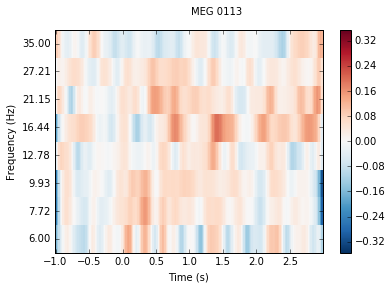

Applying baseline correction (mode: logratio)


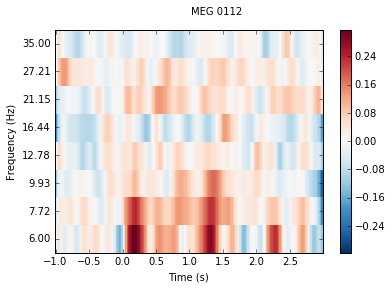

Applying baseline correction (mode: logratio)


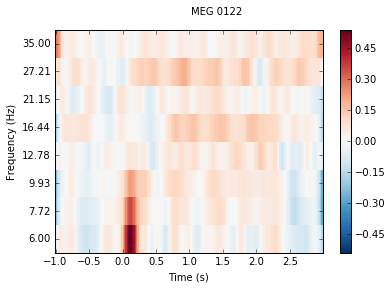

Applying baseline correction (mode: logratio)


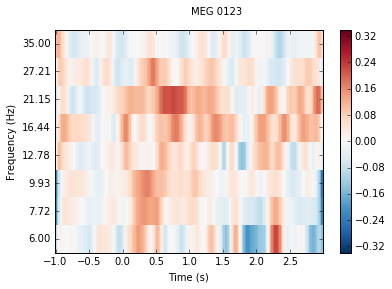

Applying baseline correction (mode: logratio)


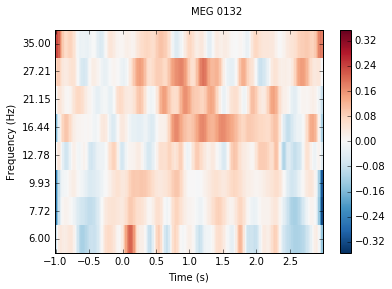

Applying baseline correction (mode: logratio)


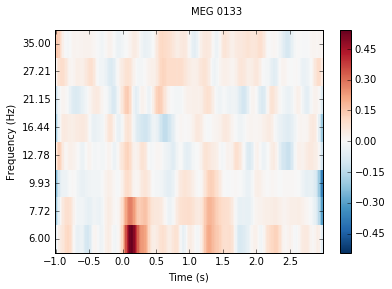

Applying baseline correction (mode: logratio)


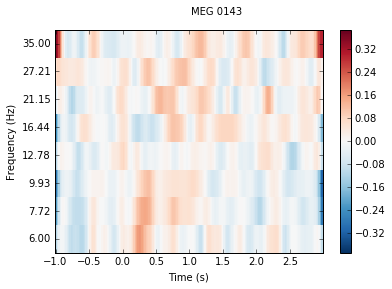

Applying baseline correction (mode: logratio)


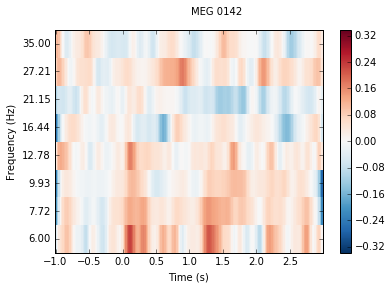

Applying baseline correction (mode: logratio)


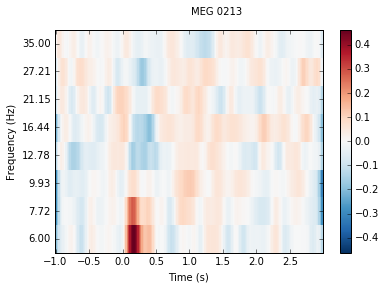

Applying baseline correction (mode: logratio)


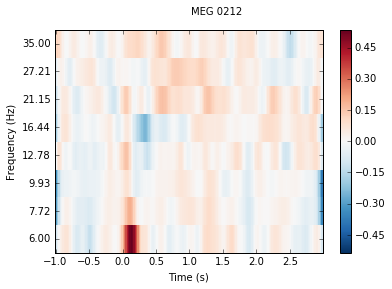

In [26]:
#Time-Frequency Representation (TFR) 
for i in range(10):
    power.plot([i], baseline=(-0.5, 0), mode='logratio', title=power.ch_names[i]);

### Joint Plot
You can also create a joint plot showing both the aggregated TFR across channels and topomaps at specific times and frequencies to obtain a quick overview regarding oscillatory effects across time and space.

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


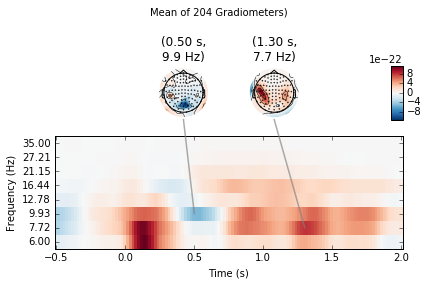

In [20]:
power.plot_joint(baseline=(-0.5, 0), mode='mean', tmin=-.5, tmax=2,
                 timefreqs=[(.5, 10), (1.3, 8)]);

### Inspect ITC


No baseline correction applied


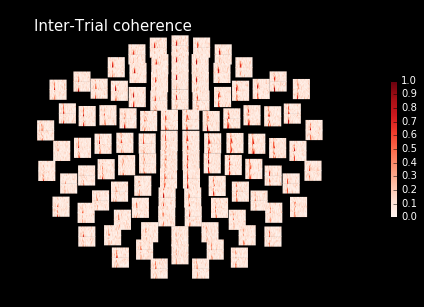

In [21]:
itc.plot_topo(title='Inter-Trial coherence', vmin=0., vmax=1., cmap='Reds');

### Reference
- https://martinos.org/mne/stable/auto_tutorials/plot_sensors_time_frequency.html
- https://martinos.org/mne/stable/auto_tutorials/plot_introduction.html#sphx-glr-auto-tutorials-plot-introduction-py